In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import load_model

Using Theano backend.


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [4]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'

nTrain = 1500
nVal = 400

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,10))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    print('----- {0}'.format(i))
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 1500 images belonging to 10 classes.
----- 1
----- 2
----- 3
----- 4
----- 5
----- 6
----- 7
----- 8
----- 9
----- 10
----- 11
----- 12
----- 13
----- 14
----- 15
----- 16
----- 17
----- 18
----- 19
----- 20
----- 21
----- 22
----- 23
----- 24
----- 25
----- 26
----- 27
----- 28
----- 29
----- 30
----- 31
----- 32
----- 33
----- 34
----- 35
----- 36
----- 37
----- 38
----- 39
----- 40
----- 41
----- 42
----- 43
----- 44
----- 45
----- 46
----- 47
----- 48
----- 49
----- 50
----- 51
----- 52
----- 53
----- 54
----- 55
----- 56
----- 57
----- 58
----- 59
----- 60
----- 61
----- 62
----- 63
----- 64
----- 65
----- 66
----- 67
----- 68
----- 69
----- 70
----- 71
----- 72
----- 73
----- 74
----- 75


In [7]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,10))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    print('----- {0}'.format(i))
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 400 images belonging to 10 classes.
----- 1
----- 2
----- 3
----- 4
----- 5
----- 6
----- 7
----- 8
----- 9
----- 10
----- 11
----- 12
----- 13
----- 14
----- 15
----- 16
----- 17
----- 18
----- 19
----- 20


## Create your own model and train the network

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=16,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data=(validation_features,validation_labels))

Train on 1500 samples, validate on 400 samples
Epoch 1/16
32s - loss: 1.0081 - acc: 0.7153 - val_loss: 0.1965 - val_acc: 0.9525
Epoch 2/16
32s - loss: 0.3874 - acc: 0.8827 - val_loss: 0.1092 - val_acc: 0.9700
Epoch 3/16
32s - loss: 0.2533 - acc: 0.9127 - val_loss: 0.0732 - val_acc: 0.9825
Epoch 4/16
33s - loss: 0.1709 - acc: 0.9453 - val_loss: 0.0736 - val_acc: 0.9775
Epoch 5/16
32s - loss: 0.1280 - acc: 0.9627 - val_loss: 0.0622 - val_acc: 0.9850
Epoch 6/16
32s - loss: 0.1271 - acc: 0.9573 - val_loss: 0.1157 - val_acc: 0.9675
Epoch 7/16
32s - loss: 0.0743 - acc: 0.9760 - val_loss: 0.0849 - val_acc: 0.9825
Epoch 8/16
32s - loss: 0.0634 - acc: 0.9773 - val_loss: 0.0668 - val_acc: 0.9850
Epoch 9/16
34s - loss: 0.0449 - acc: 0.9813 - val_loss: 0.0577 - val_acc: 0.9750
Epoch 10/16
42s - loss: 0.0462 - acc: 0.9827 - val_loss: 0.0808 - val_acc: 0.9850
Epoch 11/16
47s - loss: 0.0400 - acc: 0.9847 - val_loss: 0.0762 - val_acc: 0.9850
Epoch 12/16
47s - loss: 0.0284 - acc: 0.9900 - val_loss: 0.0

In [10]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [11]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

400/400 [==============================] - 1s     


In [12]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 9/400


### Show wrong predictions

Original label:1566-notebooks\377233.jpg, Prediction :1622-comp-case, confidence : 0.693


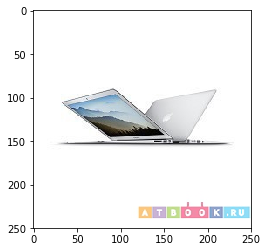

Original label:1594-ups\368473.jpg, Prediction :1622-comp-case, confidence : 1.000


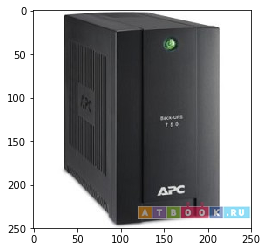

Original label:1594-ups\370303.jpg, Prediction :1622-comp-case, confidence : 0.596


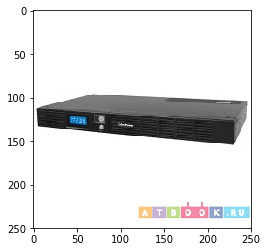

Original label:1594-ups\373523.jpg, Prediction :1654-loudspeakers, confidence : 0.936


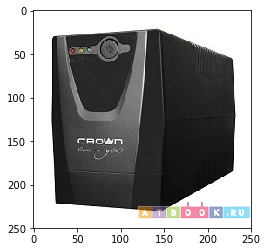

Original label:1594-ups\373863.jpg, Prediction :1622-comp-case, confidence : 0.907


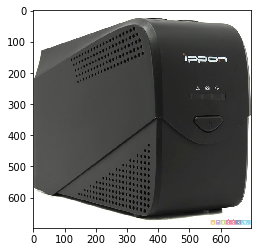

Original label:1594-ups\383983.jpg, Prediction :5270-pilot, confidence : 0.899


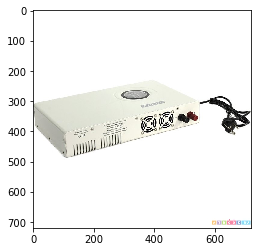

Original label:1594-ups\385223.jpg, Prediction :1622-comp-case, confidence : 0.530


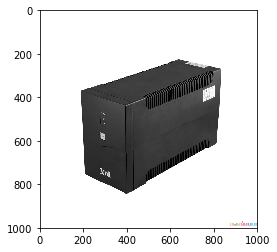

Original label:1627-usb-flash\172050.jpg, Prediction :5270-pilot, confidence : 0.990


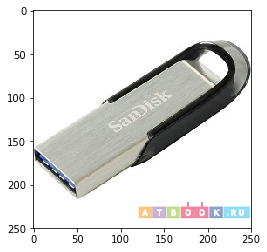

Original label:1654-loudspeakers\384185.jpg, Prediction :1622-comp-case, confidence : 0.989


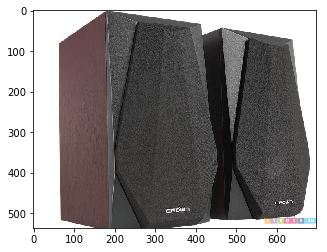

In [13]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()

### Save model for future using

In [14]:
model.save('vgg16_atbook_classif.h5')

In [ ]:
#del existing model
#del model

In [ ]:
#load model from file
#model = load_model('vgg16_binary_cls_tires_disks.h5')